In [1]:
import numpy as np
import random
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch.client import CatClient
from elasticsearch.client import IndicesClient
from elasticsearch.helpers import bulk

- Fetch data

In [4]:
train = fetch_20newsgroups(subset='train', 
                           random_state=42, 
                           categories=['rec.sport.hockey','sci.med'],
                           remove=('headers', 'footers', 'quotes'))

In [5]:
test = fetch_20newsgroups(subset='test', 
                          random_state=42, 
                          categories=['rec.sport.hockey','sci.med'],
                          remove=('headers', 'footers', 'quotes'))

In [6]:
data = [[text,target] for text,target in zip(train.data, train.target)]
train_df = pd.DataFrame(columns=['text','target'], data=data)

In [7]:
data = [[text,target] for text,target in zip(test.data, train.target)]
test_df = pd.DataFrame(columns=['text','target'], data=data)

- Preprocess text

In [8]:
# Remove punctuation characters
train_df['text'] = train_df['text'].str.replace('[^a-zA-Z0-9.-]+',' ')
train_df['text'] = train_df['text'].str.replace('[-]+','-')
train_df['text'] = train_df['text'].apply(lambda x: x.lower())

test_df['text'] = test_df['text'].str.replace('[^a-zA-Z0-9.-]+',' ')
test_df['text'] = test_df['text'].str.replace('[-]+','-')
test_df['text'] = test_df['text'].apply(lambda x: x.lower())

- Save dataframe as a json file

In [9]:
# save the dataframe to a json format
train_df.to_json('train_file.json',orient='records', lines=True)
test_df.to_json('test_file.json',orient='records', lines=True)

- open a connection to elasticsearch
- index the contents of json file

In [10]:
elastic_db = Elasticsearch(['localhost:9200'])
indices_client = IndicesClient(elastic_db)
cat_client = CatClient(elastic_db)
es_index_name = '20newsgroup'

In [11]:
# To view the indices on Elastisearch:
print(cat_client.indices(v=True))

health status index                uuid                   pri rep docs.count docs.deleted store.size pri.store.size
green  open   .kibana_1            ivC4RJfYT1G83FexxOBJnA   1   0          6            0     35.2kb         35.2kb
yellow open   my_index             YL2Go-f1QVmqw3RUzkBuhA   1   1          0            0       283b           283b
green  open   .kibana_task_manager mSVLNTzUT_KZVklF1c9X6Q   1   0          2            0     53.7kb         53.7kb
yellow open   20newsgroup          3ukDcjh9RN696kWfdOiY2Q   1   1       1194            0      1.1mb          1.1mb
yellow open   ai_coe_hackathon     f20w6aIAQ7Cma819FO23YA   1   1      17038            0     43.3mb         43.3mb



In [12]:
# Delete the index. Will recreate the index.
response = indices_client.delete(index=es_index_name, ignore_unavailable=True)
print(response)

{'acknowledged': True}


In [13]:
# To view the indices on Elastisearch:
print(cat_client.indices(v=True))

health status index                uuid                   pri rep docs.count docs.deleted store.size pri.store.size
green  open   .kibana_1            ivC4RJfYT1G83FexxOBJnA   1   0          6            0     35.2kb         35.2kb
yellow open   my_index             YL2Go-f1QVmqw3RUzkBuhA   1   1          0            0       283b           283b
green  open   .kibana_task_manager mSVLNTzUT_KZVklF1c9X6Q   1   0          2            0     53.7kb         53.7kb
yellow open   ai_coe_hackathon     f20w6aIAQ7Cma819FO23YA   1   1      17038            0     43.3mb         43.3mb



In [14]:
# Create the index
index_settings = {
    "settings": {
        "analysis": {
            "analyzer": {
                "custom_standard_analyzer": {
                    "type": "standard",                    
                    "stopwords": "_english_"
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "analyzer": "custom_standard_analyzer",
                "search_analyzer": "custom_standard_analyzer",
                "index_options": "docs",
                "norms": False
            }
        }
    }
}

response = indices_client.create(index=es_index_name, body=index_settings)
print(response)

{'acknowledged': True, 'shards_acknowledged': True, 'index': '20newsgroup'}


In [15]:
# Generator function to provide data to index into Elasticsearch
def gendata():
    with open('train_file.json','r') as f:
        for idx,line in enumerate(f):
            obj = json.loads(line)
            data = {
                '_index': es_index_name,                
                '_id': idx,
                'text': obj['text'],
                'target': obj['target']                
            }            
            yield data

In [16]:
# load all the documents into elasticsearch
response = bulk(client=elastic_db, actions=gendata(),stats_only=False)
print(response)

(1194, [])


In [17]:
# To view the indices on Elastisearch:
print(cat_client.indices(v=True))

health status index                uuid                   pri rep docs.count docs.deleted store.size pri.store.size
green  open   .kibana_1            ivC4RJfYT1G83FexxOBJnA   1   0          6            0     35.2kb         35.2kb
yellow open   my_index             YL2Go-f1QVmqw3RUzkBuhA   1   1          0            0       283b           283b
yellow open   20newsgroup          oKa7jmJGQOyQqlGV2pZcdA   1   1       1194            0      1.1mb          1.1mb
green  open   .kibana_task_manager mSVLNTzUT_KZVklF1c9X6Q   1   0          2            0     53.7kb         53.7kb
yellow open   ai_coe_hackathon     f20w6aIAQ7Cma819FO23YA   1   1      17038            0     43.3mb         43.3mb



- query document

In [18]:
def get_best_match_from_es(text_msg=''):
    # Query    
    sch_body = \
    {
        "query": {
            "match" : {
                "text" : text_msg
            }
        }
    }
    
    response = elastic_db.search(index=es_index_name, body=sch_body, 
                                 _source=True, _source_includes=['target'], 
                                 explain=False,
                                 search_type='dfs_query_then_fetch',
                                 size=1)
    
    if not response['hits']['hits']:         # if there are no matches
        label = random.choice(train.target)  # return a random choice
    else:
        label = response['hits']['hits'][0]['_source']['target']
    return label

In [19]:
# Get predictions ontest data
y_true = []
y_pred = []

with open('test_file.json','r') as f:
    for line in f:
        data = json.loads(line)
        response = get_best_match_from_es(data['text'][0:2048])
        y_true.extend([data['target']])
        y_pred.extend([response])
    # end for
# end with

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
class_names = np.array(train.target_names)

Confusion matrix, without normalization


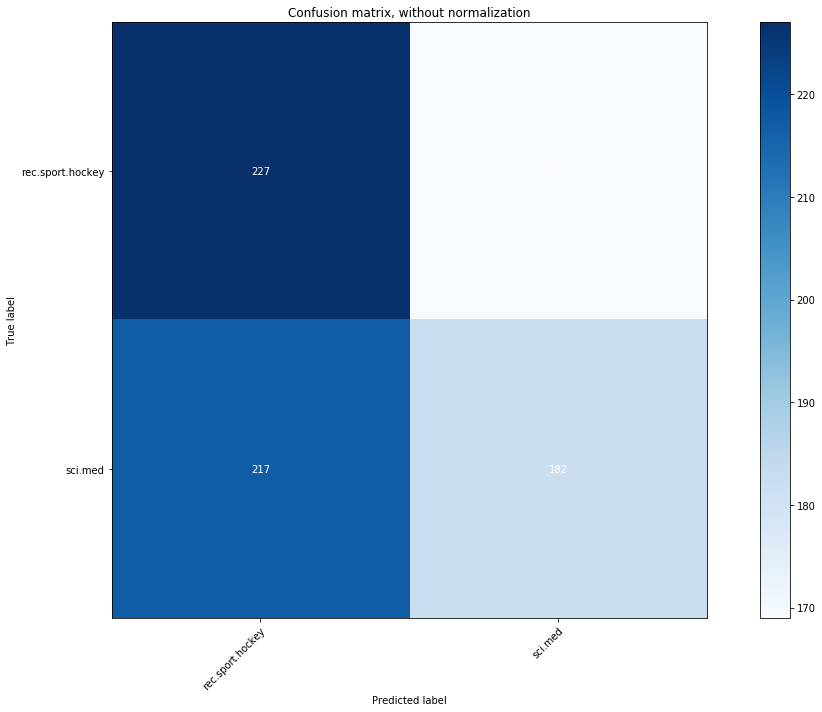

In [22]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


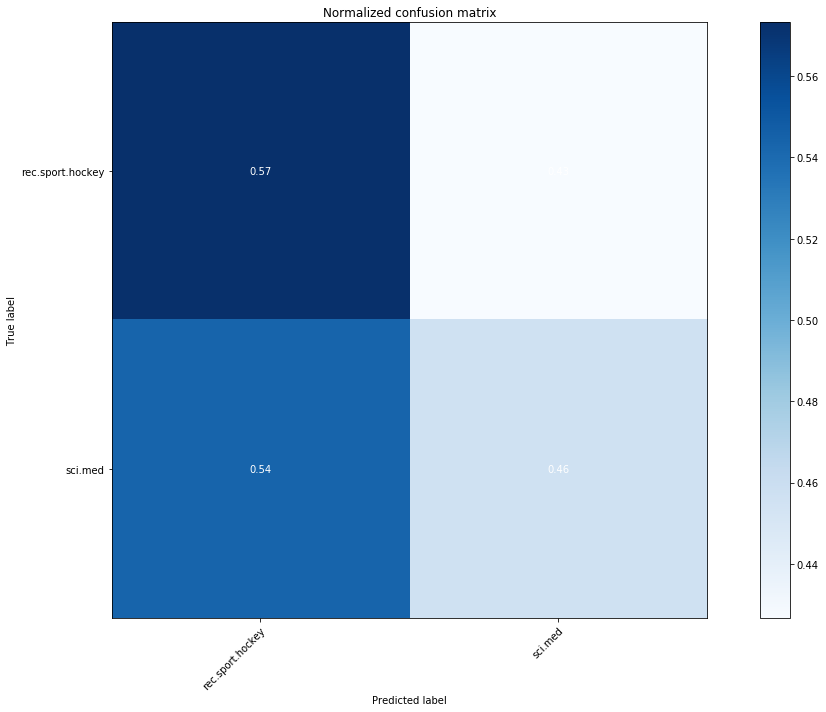

In [23]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [24]:
print('Accuracy score: {}'.format(accuracy_score(y_true, y_pred)))

Accuracy score: 0.5144654088050314
